In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
df = pd.read_csv('data.csv')
print(df.columns)

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo'],
      dtype='object')


In [2]:
%load_ext tensorboard
import datetime
import tensorflow as tf
from tensorflow.keras import layers
log_dir = "log/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#%tensorboard --logdir logs/fit

/home/jupyter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/jupyter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/jupyter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/jupyter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (typ

In [3]:
filtered_df = df.copy()
filtered_df['artists'] = filtered_df['artists'].apply(lambda x: x[1:-1].replace("'", ""))
art = filtered_df['artists'].sample()
print(len(art))
print(art.values[0])#.index[0]

1
Rush


In [4]:
filtered_df = filtered_df.drop(columns=['id']) #we dont need the spotify id's 
# remastered_list = [x for x in filtered_df.name if "remaster" in x.lower()]
# len(remastered_list)
# filtered_df = filtered_df[~filtered_df.name.isin(remastered_list)] # all the songs without the remastered 

# #are there any songs with the named remaster im discriminating against?
# #should i just get rid of everything remastered?

# skits_list = [x for x in filtered_df.name if "skit" in x.lower()]
# filtered_df = filtered_df[~filtered_df.name.isin(skits_list)]
# #28 skits a few are actual songs but idt they will be impactful

# demo_list = [x for x in filtered_df.name if "demo " in x.lower()]
# filtered_df = filtered_df[~filtered_df.name.isin(demo_list)]

In [5]:
filenames = ['classical_idx.csv','hip-hop_idx.csv','jazz_idx.csv','metal_idx.csv','reggae_idx.csv','rock_idx.csv']

gen = pd.DataFrame(0, index=np.arange(filtered_df.shape[0]),columns=['genera'])

#filtered_data['genera'] = 
for n in filenames:
    gen.iloc[pd.read_csv('genera_csv/'+n, header=None).iloc[:,0]] = n[:-8]

In [6]:
final_df = filtered_df.join(gen)
labeled_data = final_df[final_df.genera != 0]
unlabeled_data = final_df[final_df.genera == 0]

In [7]:
y = labeled_data.genera
features_list = ['valence', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']
X = labeled_data.copy()#[features_list].copy()
Z = unlabeled_data.copy()#[features_list].copy()

In [8]:
from sklearn.preprocessing import MinMaxScaler
to_norm_list = ['duration_ms', 'key','loudness', 'popularity', 'tempo']

scaler = MinMaxScaler(feature_range=(0, 1))
d = scaler.fit_transform(X[to_norm_list])
scaled_df = pd.DataFrame(d, columns=to_norm_list)
scaled_df.head()
X.drop(to_norm_list, axis=1,inplace=True)
X = X.reset_index(drop=True)
X[to_norm_list] = scaled_df
y



137       classical
229            jazz
806            jazz
814            jazz
1409           jazz
            ...    
167324       reggae
167516       reggae
168592         rock
169414         jazz
169454    classical
Name: genera, Length: 606, dtype: object

In [9]:
y.sample(20)

7262           jazz
15580       hip-hop
14021       hip-hop
10810          rock
10045        reggae
73087     classical
11582          rock
24431     classical
48422     classical
11610          rock
14099          rock
13384          rock
13259       hip-hop
10793        reggae
101396       reggae
70978          jazz
5478      classical
52346       hip-hop
165064       reggae
50918        reggae
Name: genera, dtype: object

In [10]:
y = pd.get_dummies(y)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[features_list], y,test_size=0.2)


In [81]:
d = scaler.fit_transform(Z[to_norm_list])
scaled_df = pd.DataFrame(d, columns=to_norm_list)
scaled_df.head()
Z.drop(to_norm_list, axis=1,inplace=True)
Z = Z.reset_index(drop=True)
Z[to_norm_list] = scaled_df
Z

,valence,year,acousticness,artists,danceability,energy,explicit,instrumentalness,liveness,mode,name,release_date,speechiness,genera,duration_ms,key,loudness,popularity,tempo
0,0.0594,1921,0.98200,"Sergei Rachmaninoff, James Levine, Berliner Ph...",0.279,0.211,0,0.878000,0.6650,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",1921,0.0366,0,0.153112,0.909091,0.624916,0.04,0.332450
1,0.9630,1921,0.73200,Dennis Day,0.819,0.341,0,0.000000,0.1600,1,Clancy Lowered the Boom,1921,0.4150,0,0.032496,0.636364,0.744797,0.05,0.250243
2,0.0394,1921,0.96100,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,0.328,0.166,0,0.913000,0.1010,1,Gati Bali,1921,0.0339,0,0.091685,0.272727,0.707071,0.05,0.453125
3,0.1650,1921,0.96700,Frank Parker,0.275,0.309,0,0.000028,0.3810,1,Danny Boy,1921,0.0354,0,0.037954,0.454545,0.793736,0.03,0.411113
4,0.2530,1921,0.95700,Phil Regan,0.418,0.193,0,0.000002,0.2290,1,When Irish Eyes Are Smiling,1921,0.0380,0,0.029932,0.272727,0.781521,0.02,0.417503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170042,0.6080,2020,0.08460,"Anuel AA, Daddy Yankee, KAROL G, Ozuna, J Balvin",0.786,0.808,0,0.000289,0.0822,1,China,2020-05-29,0.0881,0,0.054943,0.636364,0.881654,0.72,0.431318
170043,0.7340,2020,0.20600,Ashnikko,0.717,0.753,0,0.000000,0.1010,1,Halloweenie III: Seven Days,2020-10-23,0.0605,0,0.026961,0.636364,0.845353,0.68,0.566456
170044,0.6370,2020,0.10100,MAMAMOO,0.634,0.858,0,0.000009,0.2580,0,AYA,2020-11-03,0.0809,0,0.038191,0.363636,0.904769,0.76,0.376531
170045,0.1950,2020,0.00998,Eminem,0.671,0.623,1,0.000008,0.6430,1,Darkness,2020-01-17,0.3080,0,0.061507,0.181818,0.827484,0.70,0.308225


In [88]:
af_df = final_df.copy()
d = scaler.fit_transform(af_df[to_norm_list])
scaled_df = pd.DataFrame(d, columns=to_norm_list)
scaled_df.head()
af_df.drop(to_norm_list, axis=1,inplace=True)
af_df = af_df.reset_index(drop=True)
af_df[to_norm_list] = scaled_df
af_df

,valence,year,acousticness,artists,danceability,energy,explicit,instrumentalness,liveness,mode,name,release_date,speechiness,genera,duration_ms,key,loudness,popularity,tempo
0,0.0594,1921,0.98200,"Sergei Rachmaninoff, James Levine, Berliner Ph...",0.279,0.211,0,0.878000,0.6650,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",1921,0.0366,0,0.153112,0.909091,0.624916,0.04,0.332450
1,0.9630,1921,0.73200,Dennis Day,0.819,0.341,0,0.000000,0.1600,1,Clancy Lowered the Boom,1921,0.4150,0,0.032496,0.636364,0.744797,0.05,0.250243
2,0.0394,1921,0.96100,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,0.328,0.166,0,0.913000,0.1010,1,Gati Bali,1921,0.0339,0,0.091685,0.272727,0.707071,0.05,0.453125
3,0.1650,1921,0.96700,Frank Parker,0.275,0.309,0,0.000028,0.3810,1,Danny Boy,1921,0.0354,0,0.037954,0.454545,0.793736,0.03,0.411113
4,0.2530,1921,0.95700,Phil Regan,0.418,0.193,0,0.000002,0.2290,1,When Irish Eyes Are Smiling,1921,0.0380,0,0.029932,0.272727,0.781521,0.02,0.417503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0.6080,2020,0.08460,"Anuel AA, Daddy Yankee, KAROL G, Ozuna, J Balvin",0.786,0.808,0,0.000289,0.0822,1,China,2020-05-29,0.0881,0,0.054943,0.636364,0.881654,0.72,0.431318
170649,0.7340,2020,0.20600,Ashnikko,0.717,0.753,0,0.000000,0.1010,1,Halloweenie III: Seven Days,2020-10-23,0.0605,0,0.026961,0.636364,0.845353,0.68,0.566456
170650,0.6370,2020,0.10100,MAMAMOO,0.634,0.858,0,0.000009,0.2580,0,AYA,2020-11-03,0.0809,0,0.038191,0.363636,0.904769,0.76,0.376531
170651,0.1950,2020,0.00998,Eminem,0.671,0.623,1,0.000008,0.6430,1,Darkness,2020-01-17,0.3080,0,0.061507,0.181818,0.827484,0.70,0.308225


In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=15, restore_best_weights=True)

In [13]:


model = tf.keras.Sequential()
model.add(layers.Dense(units=12, input_shape=(len(features_list),)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=300, activation='sigmoid'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

# model.add(layers.ReLU())
model.add(layers.Dense(units=6, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy', 'mse'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                156       
_________________________________________________________________
batch_normalization (BatchNo (None, 12)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 300)               3900      
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1806      
Tota

In [14]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=400, batch_size=20, callbacks=[tensorboard_callback, early_stop])

Train on 484 samples, validate on 122 samples
Epoch 1/400
484/484 [==============================] - 0s 601us/sample - loss: 2.2912 - categorical_accuracy: 0.1860 - mean_squared_error: 0.1657 - val_loss: 1.7793 - val_categorical_accuracy: 0.1639 - val_mean_squared_error: 0.1383
Epoch 2/400
484/484 [==============================] - 0s 117us/sample - loss: 2.1405 - categorical_accuracy: 0.2107 - mean_squared_error: 0.1586 - val_loss: 1.7270 - val_categorical_accuracy: 0.3525 - val_mean_squared_error: 0.1351
Epoch 3/400
484/484 [==============================] - 0s 138us/sample - loss: 2.0943 - categorical_accuracy: 0.2707 - mean_squared_error: 0.1557 - val_loss: 1.6808 - val_categorical_accuracy: 0.3525 - val_mean_squared_error: 0.1324
Epoch 4/400
484/484 [==============================] - 0s 151us/sample - loss: 1.8976 - categorical_accuracy: 0.3244 - mean_squared_error: 0.1431 - val_loss: 1.6347 - val_categorical_accuracy: 0.3525 - val_mean_squared_error: 0.1298
Epoch 5/400
484/484 [=

Minimum Validation Loss: 0.4271


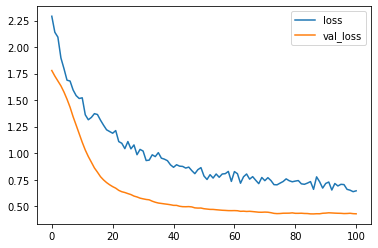

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

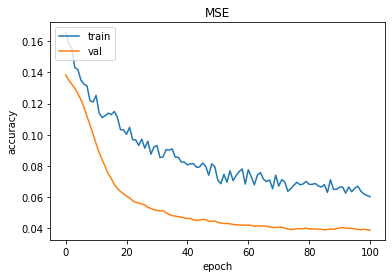

In [16]:
from matplotlib import pyplot as plt
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

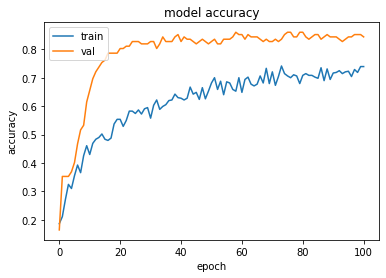

In [17]:
from matplotlib import pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
history.history

{'loss': [2.2912292332688637,
  2.1404912200841038,
  2.0943352210620216,
  1.8976128830397425,
  1.7973781971892049,
  1.688168748351168,
  1.680202636836974,
  1.5960642789021011,
  1.5428474880447072,
  1.5156352510137006,
  1.522028888552642,
  1.3618978656027927,
  1.315145037390969,
  1.337025570967966,
  1.372529037235197,
  1.3646193466895868,
  1.3112599583696727,
  1.2639093921204243,
  1.2203325412490151,
  1.2040263572015053,
  1.1880327024735695,
  1.2130317338242018,
  1.1092497061106785,
  1.0932107168780871,
  1.0427935135758613,
  1.1094993540078155,
  1.0405948403453038,
  1.0775153489152263,
  0.9854581543236725,
  1.0354462669900626,
  1.0199157945380724,
  0.9304981822809897,
  0.9344309647221211,
  0.9845870408144864,
  0.9675349455234433,
  1.004885857016587,
  0.9529582725083532,
  0.9434027322067702,
  0.9290995627395378,
  0.889772822664789,
  0.8667356514733685,
  0.8908105128067584,
  0.8773999366878478,
  0.8750589076152517,
  0.8593963847672643,
  0.868532

In [21]:
y_test

,classical,hip-hop,jazz,metal,reggae,rock
131782,0,0,0,0,1,0
53486,0,1,0,0,0,0
10430,0,0,0,0,0,1
7262,0,0,1,0,0,0
48422,1,0,0,0,0,0
...,...,...,...,...,...,...
6658,0,0,1,0,0,0
12432,0,0,0,1,0,0
35343,0,1,0,0,0,0
58817,1,0,0,0,0,0


In [25]:
# np.round(model.predict(X_test), 3)
pred = pd.DataFrame(model.predict(X_test))

In [29]:
pred.idxmax(axis=1)

0      4
1      1
2      5
3      2
4      0
      ..
117    4
118    3
119    1
120    0
121    4
Length: 122, dtype: int64

In [46]:
pred_labels = pd.Series([y.columns[x] for x in pred.idxmax(axis=1)])

In [47]:
y_labels = y_test.idxmax(axis=1)
y_labels = y_labels.reset_index(drop=True)
y_labels

0         reggae
1        hip-hop
2           rock
3           jazz
4      classical
         ...    
117         jazz
118        metal
119      hip-hop
120    classical
121       reggae
Length: 122, dtype: object

In [70]:
y_labels[y_labels != pred_labels]

6           jazz
9         reggae
10          jazz
13          jazz
19          rock
24     classical
31        reggae
33          jazz
35         metal
38          rock
45          rock
58       hip-hop
62        reggae
75          jazz
86       hip-hop
91         metal
111         jazz
117         jazz
dtype: object

In [71]:
print(y.columns)
np.round(pred.iloc[y_labels[y_labels != pred_labels].index, :], 3)

Index(['classical', 'hip-hop', 'jazz', 'metal', 'reggae', 'rock'], dtype='object')


,0,1,2,3,4,5
6,0.010,0.018,0.249,0.020,0.072,0.630
9,0.002,0.020,0.229,0.000,0.319,0.430
10,0.058,0.004,0.379,0.056,0.019,0.485
13,0.110,0.185,0.110,0.000,0.595,0.000
19,0.000,0.689,0.007,0.026,0.043,0.234
24,0.386,0.001,0.557,0.003,0.009,0.045
31,0.141,0.000,0.086,0.036,0.046,0.691
33,0.898,0.000,0.101,0.000,0.001,0.000
35,0.000,0.015,0.002,0.448,0.004,0.530
38,0.007,0.347,0.310,0.010,0.174,0.152


In [89]:
af_pred = model.predict(af_df[features_list])

In [94]:
to_concat = pd.DataFrame(np.round(af_pred, 3), columns=y.columns)

In [100]:
pd.concat([final_df, to_concat], axis=1).to_csv('net_preds.csv')